In [1]:
__depends__ = [
    "../../../data/database-results/phase-1/timestamp.txt",
    "../../../data/database-observations/timestamp.txt",
]
__dest__ = [
    "../../../figures/tas-obs-rcmip-cmip5-cmip6-comparison.pdf",
    "../../../figures/effrf-rcmip-comparison.pdf",
    "../../../figures/effrf-aerosols-rcmip-comparison.pdf",
    "../../../figures/effrf-total-aerosols-rcmip-comparison.pdf",
]

In [2]:
TAS_COMPARISON_FIGURE_PDF = __dest__[0]
EFFRF_COMPARISON_FIGURE_PDF = __dest__[1]
EFFRF_AEROSOLS_COMPARISON_FIGURE_PDF = __dest__[2]
EFFRF_PANEL_COMPARISON_FIGURE_PDF = __dest__[3]

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Historical comparisons

In [4]:
import glob
import logging
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import pyam
import scipy.stats
import tqdm

from pymagicc.io import MAGICCData
from scmdata import df_append, ScmDataFrame

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns

%matplotlib inline

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from utils import (
    aggregate_effective_aerosol_forcing,
    clean_labels,
    convert_scmdf_to_pyamdf_year_only,
    get_interest_period_mean,
    get_interest_period_slope,
    load_database_files,
    prep_str_for_filename,
    reduce_to_one_variant_per_model,
)

<IPython.core.display.Javascript object>

In [6]:
logger = logging.getLogger()

<IPython.core.display.Javascript object>

In [7]:
color_map_scenarios_base = {
    "ssp119": "AR6-SSP1-1.9",
    "ssp126": "AR6-SSP1-2.6",
    "ssp245": "AR6-SSP2-4.5",
    "ssp370": "AR6-SSP3-7.0",
    "ssp370-lowNTCF": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-gidden": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-aerchemmip": "AR6-SSP3-LowNTCF",
    "ssp434": "AR6-SSP4-3.4",
    "ssp460": "AR6-SSP4-6.0",
    "ssp585": "AR6-SSP5-8.5",
    "ssp534-over": "AR6-SSP5-3.4-OS",
    "historical": "black",
    "rcp26": "AR5-RCP-2.6",
    "rcp45": "AR5-RCP-4.5",
    "rcp60": "AR5-RCP-6.0",
    "rcp85": "AR5-RCP-8.5",
    "historical-cmip5": "tab:gray",
}

color_map_scenarios = {}
for k, v in color_map_scenarios_base.items():
    color_map_scenarios[k] = v
    color_map_scenarios["esm-{}".format(k)] = v
    color_map_scenarios["esm-{}-allGHG".format(k)] = v

pyam.run_control().update({"color": {"scenario": color_map_scenarios}})

<IPython.core.display.Javascript object>

In [8]:
color_map_models = {"Observations (Priestley Centre)": "black"}

pyam.run_control().update({"color": {"climatemodel": color_map_models}})

<IPython.core.display.Javascript object>

## Load data

### Observations

In [9]:
OBS_PATH = os.path.join("..", "..", "..", "data", "database-observations")
OBS_PATH

'../../../data/database-observations'

<IPython.core.display.Javascript object>

In [10]:
db_obs = pyam.concat(glob.glob(os.path.join(OBS_PATH, "*.csv")))
db_obs.timeseries().head()

INFO:root:Reading `../../../data/database-observations/rcmip-observations_observations-priestley-centre_world_surface-air-temperature-change.csv`


1850  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.042412   

                                                                                                       1851  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.123588   

                                                                                                       1852  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.085588   

                                                                                                       1853  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.025588   

                                                                                                       1854  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.086588   

                                                                                                       1855  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.087588   

                                                                                                       1856  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.040412   

                                                                                                       1857  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.138412   

                                                                                                       1858  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.074412   

                                                                                                       1859  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.012412   

                                                                                                   ...  \
model       scenario   region variable                       unit climatemodel                     ...   
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  ...   

                                                                                                       2009  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.976085   

                                                                                                       2010  \

<IPython.core.display.Javascript object>

In [11]:
db_obs.variables(True)

variable unit
0  Surface Air Temperature Change    K

<IPython.core.display.Javascript object>

### RCMIP results

In [12]:
RESULTS_PATH = os.path.join("..", "..", "..", "data", "database-results", "phase-1")
RESULTS_PATH

'../../../data/database-results/phase-1'

<IPython.core.display.Javascript object>

In [13]:
model_of_interest = [
    ".*acc2.*",
    ".*ar5ir.*",
    ".*cicero-scm.*",
    ".*escimo.*",
    ".*fair-1.5.*",
    ".*gir.*",
    ".*greb.*",
    ".*hector.*",
    ".*held-two-layer-uom.*",
    ".*magicc7.*",
    ".*mce.*",
    ".*oscar.*",
    ".*wasp.*",
]

results_files = list(Path(RESULTS_PATH).rglob("*.csv")) + list(
    Path(RESULTS_PATH).rglob("*.xlsx")
)
results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print("Number of available files: {}".format(len(results_files)))
results_files[:5]

Number of available files: 1375


['../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip5-mri-cgcm3-calib_world_net-ocean-to-atmosphere-flux-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_emissions-ch4.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_radiative-forcing-anthropogenic-f-gases-hfc-hfc134a.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-cams-csm1-0-calib_world_net-ocean-to-atmosphere-flux-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-canesm5-calib_world_heat-content-ocean.csv']

<IPython.core.display.Javascript object>

In [14]:
variables_of_interest = [
    "Surface Air Temperature Change",
    #     "Surface Ocean Temperature Change",
    #     "Surface Air Ocean Blended Temperature Change",
    "effective-radiative-forcing\.csv",
    "Effective Radiative Forcing|Anthropogenic|Aerosols",
    "Effective Radiative Forcing|Anthropogenic|Other",
]

relevant_files = [
    str(p)
    for p in results_files
    if any(
        [
            bool(re.match(".*{}.*".format(prep_str_for_filename(v)), str(p)))
            for v in variables_of_interest
        ]
    )
]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files[:5]

Number of relevant files: 238


['../../../data/database-results/phase-1/rcmip-phase-1_escimo,rcmip,base_world_effective-radiative-forcing.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip5-cnrm-cm5-calib_world_surface-air-temperature-change.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_held-two-layer-uom-cmip6-cnrm-esm2-1-r1i1p1f2-calib_world_surface-air-temperature-change.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_held-two-layer-uom-cmip6-ec-earth3-veg-r1i1p1f1-calib_world_effective-radiative-forcing.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_ar5ir3box-cmip6-mpi-esm1-2-hr-r1i1p1f1-calib_world_effective-radiative-forcing.csv']

<IPython.core.display.Javascript object>

In [15]:
logging.getLogger("scmdata").setLevel(logging.WARNING)
db = load_database_files(relevant_files)
logging.getLogger("scmdata").setLevel(logging.INFO)
db.head()

time                                                                                                                 1750-01-01 00:00:00  \
model scenario region                    variable                       unit climatemodel              unit_context                        
GREB  1pctCO2  World                     Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|Northern Hemisphere Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2ASIA            Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2LAM             Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2MAF             Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   

time                                                                                                                 1751-01-01 00:00:00  \
model scenario region                    variable                       unit climatemodel              unit_context                        
GREB  1pctCO2  World                     Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|Northern Hemisphere Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2ASIA            Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2LAM             Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2MAF             Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   

time                                                                                                                 1752-01-01 00:00:00  \
model scenario region                    variable                       unit climatemodel              unit_context                        
GREB  1pctCO2  World                     Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|Northern Hemisphere Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2ASIA            Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2LAM             Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2MAF             Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   

time                                                                                                                 1753-01-01 00:00:00  \
model scenario region                    variable                       unit climatemodel              unit_context                        
GREB  1pctCO2  World                     Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|Northern Hemisphere Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2ASIA            Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2LAM             Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   
               World|R5.2MAF             Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL not_required                  NaN   

time                                                                        

<IPython.core.display.Javascript object>

### CMIP5 and CMIP6 data

In [16]:
CMIP_PROCESSED_DATA_PATH = os.path.join("..", "..", "..", "data", "cmip-output")
CMIP_PROCESSED_DATA_PATH

'../../../data/cmip-output'

<IPython.core.display.Javascript object>

In [17]:
def load_tas_file(f):
    out = MAGICCData(f)
    metadata = out.metadata
    assert out["variable"].unique().tolist() == ["tas"]
    out.set_meta("Surface Air Temperature Change", "variable")
    try:
        source_id = out.metadata["(child) source_id"]
        variant_id = out.metadata["(child) variant_label"]
        cmip = "CMIP6"
    except KeyError:
        source_id = out.metadata["(child) model_id"]
        variant_id = os.path.basename(f).split("_")[-2]
        cmip = "CMIP5"

    out.set_meta(source_id, "source_id")
    out.set_meta("_".join([source_id, variant_id]), "climatemodel")
    out.set_meta(out.metadata["(child) experiment_id"], "scenario")
    out.set_meta(cmip, "mip_era")

    out = out.timeseries().reset_index().drop(["todo", "climate_model"], axis="columns")

    out = MAGICCData(out)
    out.metadata = metadata

    return out


cmip_files = glob.glob(os.path.join(CMIP_PROCESSED_DATA_PATH, "NORMED*tas*.MAG"))

db_cmip = df_append(
    [load_tas_file(f).filter(region="World") for f in tqdm.tqdm_notebook(cmip_files)]
)
db_cmip.head()

time                                                                                                          1850-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.235092   
                                                                    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.072296   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.237105   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.300191   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    1.179010   

time                                                                                                          1851-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.110569   
                                                                    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.108386   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.146162   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.271106   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    1.769500   

time                                                                                                          1852-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.128055   
                                                                    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.082006   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.115545   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.288205   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    2.204930   

time                                                                                                          1853-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.200446   
                                                                    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.031320   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.051096   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.314625   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    2.333120   

time                                                                                                          1854-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.141776   
                                                                    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.022090   
            1pctCO2-bgc  Wor

<IPython.core.display.Javascript object>

## Plot

### Temperature

In [18]:
matplotlib.rcParams["figure.figsize"] = (6, 4)
matplotlib.rcParams["font.size"] = 6

<IPython.core.display.Javascript object>

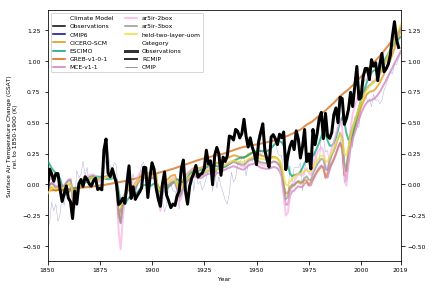

<IPython.core.display.Javascript object>

In [19]:
variable_to_plot = [
    "Surface Air Temperature Change",
    "Surface Air Temperature Change|50th quantile",
]
region_to_plot = "World"
scenario_obs = "historical"
scenario_models = "ssp585"
scenario_cmip = ["ssp585", "rcp85"]
rcmip_climatemodel_ignore_filter = [
    "*CALIB*",
    "MAGICC*_*",
    "*CMIP5-mean",
    "FaIR-1.5-ENS",
    "WASP,2,PROB-hist",
    "Cicero-SCM",
    "MCE,v1-1,DEFAULT",
    "MCE,v1-1,PROB",
]
broken_cmip5_climatemodel = [
    "HadGEM2-CC_r1i1p1",
    "HadGEM2-CC_r2i1p1",
    "HadGEM2-CC_r3i1p1",
]

years_to_plot = range(1850, 2020)
reference_period = (1961, 1990)  # bounds are inclusive
reference_period = (1850, 1900)  # bounds are inclusive


def prep_for_plot(idf):
    if isinstance(idf, pyam.IamDataFrame):
        udf = ScmDataFrame(idf)
    else:
        udf = idf.copy()

    udf = ScmDataFrame(
        udf.relative_to_ref_period_mean(
            year=range(reference_period[0], reference_period[1] + 1)
        )
    )

    return convert_scmdf_to_pyamdf_year_only(udf)


pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(TAS_COMPARISON_FIGURE_PDF)

fig, ax = plt.subplots(nrows=1, ncols=1)
assert isinstance(db_obs, pyam.IamDataFrame)

pdf_obs = prep_for_plot(
    db_obs.filter(
        variable=variable_to_plot,
        region=region_to_plot,
        scenario=scenario_obs,
        year=years_to_plot,
    )
).data

pdf_rcmip = prep_for_plot(
    db.filter(
        variable=variable_to_plot,
        region=region_to_plot,
        scenario=scenario_models,
        year=years_to_plot,
    )
    .filter(climatemodel=rcmip_climatemodel_ignore_filter, keep=False)
    .append(
        db.filter(  # ACC2 only has esm results
            variable=variable_to_plot,
            region=region_to_plot,
            scenario="esm-" + scenario_models + "-allGHG",
            year=years_to_plot,
            climatemodel="*ACC2*",
        )
    )
).data

pdf_cmip = prep_for_plot(
    db_cmip.filter(
        variable=variable_to_plot,
        region=region_to_plot,
        scenario=scenario_cmip,
        year=years_to_plot,
    ).filter(climatemodel=broken_cmip5_climatemodel, keep=False)
)

pdf_cmip = reduce_to_one_variant_per_model(pdf_cmip).data

pdf_sns = pd.concat([pdf_obs, pdf_rcmip, pdf_cmip], sort=True)

pdf_sns["Category"] = "RCMIP"
pdf_sns.loc[~pdf_sns["source_id"].isnull(), "Category"] = "CMIP"
pdf_sns.loc[
    pdf_sns["climatemodel"].str.startswith("Observations"), "Category"
] = "Observations"

sizes = {"Observations": 3, "CMIP": 0.5, "RCMIP": 2}

pdf_sns["Climate Model"] = pdf_sns["climatemodel"]
pdf_sns.loc[pdf_sns["mip_era"] == "CMIP5", "Climate Model"] = "CMIP5"
pdf_sns.loc[pdf_sns["mip_era"] == "CMIP6", "Climate Model"] = "CMIP6"

climatemodels = sorted(pdf_sns["Climate Model"].unique())
obs_key = [cm for cm in climatemodels if cm.startswith("Observations")][0]
hue_order = [obs_key] + [cm for cm in sorted(climatemodels) if cm != obs_key]
sns_colours = sns.color_palette("colorblind", len(climatemodels))

palette = {cm: sns_colours[i] for i, cm in enumerate(climatemodels)}
palette[obs_key] = "black"
palette["CMIP5"] = "darkgray"
palette["CMIP6"] = "darkblue"

dashes_set = ("", (3, 3), (1, 1))
dashes = {
    cm: dashes_set[i // len(set(sns_colours))] for i, cm in enumerate(climatemodels)
}
dashes[obs_key] = ""
dashes["CMIP5"] = ""
dashes["CMIP6"] = ""

sns.lineplot(
    data=pdf_sns,
    x="year",
    y="value",
    units="climatemodel",
    hue="Climate Model",
    hue_order=hue_order,
    style="Climate Model",
    dashes=dashes,
    palette=palette,
    ax=ax,
    size="Category",
    sizes=sizes,
    estimator=None,
)


clean_labels(ax, ignore=["Category", "Climate Model"])
legend = ax.legend(loc="upper left", ncol=2)

for l in ax.get_lines():
    if l.get_linewidth() == 3:
        l.set_zorder(10)
    elif l.get_linewidth() == 2:
        l.set_zorder(5)
        l.set_alpha(0.7)
    else:
        l.set_alpha(0.3)


ax.set_ylabel(
    "Surface Air Temperature Change (GSAT)\nrel. to {}-{} (K)".format(
        reference_period[0], reference_period[1]
    )
)
ax.set_xlabel("Year")
ax.set_xlim([1850, 2019])
ax.tick_params(labelright=True, right=True)
ax.set_xticks(list(range(1850, 2011, 25)) + [2019])

plt.tight_layout()
pdf_to_save.savefig(fig)
#     break

pdf_to_save.close()

#### Some basic analysis too

In [20]:
interest_period = (2000, 2019)  # inclusive bounds

<IPython.core.display.Javascript object>

In [21]:
interest_period_long = (1970, 2000)  # inclusive bounds
interest_period_long = (1989, 2019)  # inclusive bounds

<IPython.core.display.Javascript object>

In [22]:
pdf_rcmip_analysis_interest_period_mean = get_interest_period_mean(
    pdf_rcmip, interest_period
)
pdf_rcmip_analysis_interest_period_mean.to_frame().head()

0
model          scenario region variable                                           unit climatemodel              unit_context          
GREB           ssp585   World  Surface Air Temperature Change (ref. period yea... K    GREB-v1.0.1-ECMWF_IFS-ALL not_required  1.058398
REMIND-MAGPIE  ssp585   World  Surface Air Temperature Change (ref. period yea... K    ar5ir2box-ECS-3K          not_required  0.969410
                                                                                       ar5ir3box-ECS-3K          not_required  0.953624
                                                                                       held-two-layer-uom-ECS-3K not_required  0.952996
not applicable ssp585   World  Surface Air Temperature Change (ref. period yea... K    ESCIMO,rcmip,base         not_required  0.974079

<IPython.core.display.Javascript object>

In [23]:
pdf_rcmip_analysis_interest_period_mean.describe()

count    7.000000
mean     0.942971
std      0.079513
min      0.801538
25%      0.921875
50%      0.953624
75%      0.971745
max      1.058398
dtype: float64

<IPython.core.display.Javascript object>

In [24]:
pdf_obs["variable"].unique()

array(['Surface Air Temperature Change (ref. period year: 1850 - 1900)'],
      dtype=object)

<IPython.core.display.Javascript object>

In [25]:
get_interest_period_mean(pdf_rcmip, interest_period_long).describe()

count    7.000000
mean     0.766701
std      0.103186
min      0.623523
25%      0.723181
50%      0.759508
75%      0.789915
max      0.957685
dtype: float64

<IPython.core.display.Javascript object>

In [26]:
get_interest_period_mean(pdf_obs, interest_period).describe()

count    1.000000
mean     0.990198
std           NaN
min      0.990198
25%      0.990198
50%      0.990198
75%      0.990198
max      0.990198
dtype: float64

<IPython.core.display.Javascript object>

In [27]:
get_interest_period_mean(pdf_obs, interest_period_long).describe()

count    1.000000
mean     0.872186
std           NaN
min      0.872186
25%      0.872186
50%      0.872186
75%      0.872186
max      0.872186
dtype: float64

<IPython.core.display.Javascript object>

In [28]:
get_interest_period_mean(pdf_cmip, interest_period).describe()

count    1.000000
mean     0.794246
std           NaN
min      0.794246
25%      0.794246
50%      0.794246
75%      0.794246
max      0.794246
dtype: float64

<IPython.core.display.Javascript object>

In [29]:
get_interest_period_mean(pdf_cmip, interest_period_long).describe()

count    1.000000
mean     0.635129
std           NaN
min      0.635129
25%      0.635129
50%      0.635129
75%      0.635129
max      0.635129
dtype: float64

<IPython.core.display.Javascript object>

In [30]:
pdf_rcmip_analysis_interest_period_slope = get_interest_period_slope(
    pdf_rcmip, interest_period
)
pdf_rcmip_analysis_interest_period_slope.to_frame()

0
model          scenario region variable                                           unit climatemodel              unit_context          
GREB           ssp585   World  Surface Air Temperature Change (ref. period yea... K    GREB-v1.0.1-ECMWF_IFS-ALL not_required  0.020358
REMIND-MAGPIE  ssp585   World  Surface Air Temperature Change (ref. period yea... K    ar5ir2box-ECS-3K          not_required  0.024203
                                                                                       ar5ir3box-ECS-3K          not_required  0.030179
                                                                                       held-two-layer-uom-ECS-3K not_required  0.031874
not applicable ssp585   World  Surface Air Temperature Change (ref. period yea... K    ESCIMO,rcmip,base         not_required  0.024710
not_applicable ssp585   World  Surface Air Temperature Change (ref. period yea... K    MCE,v1-1,ECS3K            not_required  0.025499
unspecified    ssp585   World  Surface Air Temperature Change (ref. period yea... K    Cicero-SCM-ECS3           not_required  0.030389

<IPython.core.display.Javascript object>

In [31]:
pdf_rcmip_analysis_interest_period_slope.describe()

count    7.000000
mean     0.026744
std      0.004170
min      0.020358
25%      0.024456
50%      0.025499
75%      0.030284
max      0.031874
dtype: float64

<IPython.core.display.Javascript object>

In [32]:
get_interest_period_slope(pdf_rcmip, interest_period_long).describe()

count    7.000000
mean     0.030264
std      0.005495
min      0.018739
25%      0.029655
50%      0.031294
75%      0.034080
max      0.034347
dtype: float64

<IPython.core.display.Javascript object>

In [33]:
get_interest_period_slope(pdf_obs, interest_period).describe()

count    1.000000
mean     0.019494
std           NaN
min      0.019494
25%      0.019494
50%      0.019494
75%      0.019494
max      0.019494
dtype: float64

<IPython.core.display.Javascript object>

In [34]:
get_interest_period_slope(pdf_obs, interest_period_long).describe()

count    1.000000
mean     0.021127
std           NaN
min      0.021127
25%      0.021127
50%      0.021127
75%      0.021127
max      0.021127
dtype: float64

<IPython.core.display.Javascript object>

In [35]:
get_interest_period_slope(pdf_cmip, interest_period).describe()

count    1.0000
mean     0.0197
std         NaN
min      0.0197
25%      0.0197
50%      0.0197
75%      0.0197
max      0.0197
dtype: float64

<IPython.core.display.Javascript object>

In [36]:
get_interest_period_slope(pdf_cmip, interest_period_long).describe()

count    1.000000
mean     0.026056
std           NaN
min      0.026056
25%      0.026056
50%      0.026056
75%      0.026056
max      0.026056
dtype: float64

<IPython.core.display.Javascript object>

### Effective radiative forcing

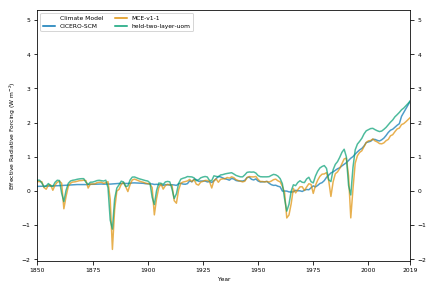

<IPython.core.display.Javascript object>

In [37]:
variable_to_plot = [
    "Effective Radiative Forcing",
    "Effective Radiative Forcing|50th quantile",
]
region_to_plot = "World"
scenario_models = "ssp585"
broken_rcmip_results = ["*ESCIMO*"]  # up around 200...

years_to_plot = range(1850, 2050)


def prep_for_plot(idf):
    if isinstance(idf, pyam.IamDataFrame):
        udf = ScmDataFrame(idf)
    else:
        udf = idf.copy()

    return convert_scmdf_to_pyamdf_year_only(udf)


pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(EFFRF_COMPARISON_FIGURE_PDF)

fig, ax = plt.subplots(nrows=1, ncols=1)

pdf_rcmip = prep_for_plot(
    db.filter(
        variable=variable_to_plot,
        region=region_to_plot,
        scenario=scenario_models,
        year=years_to_plot,
    ).filter(
        climatemodel=rcmip_climatemodel_ignore_filter + broken_rcmip_results, keep=False
    )
).data

pdf_sns = pd.concat([pdf_rcmip], sort=True)

pdf_sns["Category"] = "RCMIP"
sizes = {"Observations": 3, "CMIP": 0.5, "RCMIP": 2}

pdf_sns["Climate Model"] = pdf_sns["climatemodel"]

climatemodels = sorted(pdf_sns["Climate Model"].unique())
hue_order = sorted(climatemodels)
sns_colours = sns.color_palette("colorblind", len(climatemodels))

palette = {cm: sns_colours[i] for i, cm in enumerate(climatemodels)}

dashes_set = ("", (3, 3))
dashes = {
    cm: dashes_set[i // len(set(sns_colours))] for i, cm in enumerate(climatemodels)
}

sns.lineplot(
    data=pdf_sns,
    x="year",
    y="value",
    units="climatemodel",
    hue="Climate Model",
    hue_order=hue_order,
    style="Climate Model",
    dashes=dashes,
    palette=palette,
    ax=ax,
    estimator=None,
    alpha=0.7,
)

clean_labels(ax, ignore=["Category", "Climate Model"])
ax.legend(loc="upper left", ncol=2)

ax.set_ylabel("Effective Radiative Forcing (W m$^{-2}$)")
ax.set_xlabel("Year")
ax.set_xlim([1850, 2019])
ax.tick_params(labelright=True, right=True)
ax.set_xticks(list(range(1850, 2011, 25)) + [2019])

plt.tight_layout()
pdf_to_save.savefig(fig)
#     break

pdf_to_save.close()

### Effective radiative forcing due to aerosols

In [38]:
db_plus_agg = aggregate_effective_aerosol_forcing(db)
db_plus_agg.filter(variable="*Aerosols")["variable"].unique()

/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:61: UserWarning: No Effective Radiative Forcing|Anthropogenic|Aerosols data for FaIR-1.5*
  warnings.warn("No {} data for {}".format(var_to_agg, cm))
/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:61: UserWarning: No Effective Radiative Forcing|Anthropogenic|Aerosols data for OSCARv3.0
  warnings.warn("No {} data for {}".format(var_to_agg, cm))
/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:61: UserWarning: No Effective Radiative Forcing|Anthropogenic|Aerosols data for WASP,2,PROB*
  warnings.warn("No {} data for {}".format(var_to_agg, cm))
/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:67: UserWarning: No ['Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions', 'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions'] data for MAGICC7.1.0.beta*
  warnings.

array(['Effective Radiative Forcing|Anthropogenic|Aerosols'], dtype=object)

<IPython.core.display.Javascript object>

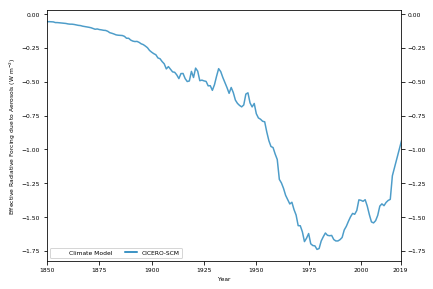

<IPython.core.display.Javascript object>

In [39]:
variable_to_plot = [
    "Effective Radiative Forcing|Anthropogenic|Aerosols",
    "Effective Radiative Forcing|Anthropogenic|Aerosols|50th quantile",
]
region_to_plot = "World"
scenario_models = "ssp585"
broken_rcmip_results = ["*ESCIMO*"]  # up around 200...

years_to_plot = range(1850, 2050)


def prep_for_plot(idf):
    if isinstance(idf, pyam.IamDataFrame):
        udf = ScmDataFrame(idf)
    else:
        udf = idf.copy()

    return convert_scmdf_to_pyamdf_year_only(udf)


pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(
    EFFRF_AEROSOLS_COMPARISON_FIGURE_PDF
)

fig, ax = plt.subplots(nrows=1, ncols=1)

pdf_rcmip = prep_for_plot(
    db_plus_agg.filter(
        variable=variable_to_plot,
        region=region_to_plot,
        scenario=scenario_models,
        year=years_to_plot,
    ).filter(
        climatemodel=rcmip_climatemodel_ignore_filter + broken_rcmip_results, keep=False
    )
).data

pdf_sns = pd.concat([pdf_rcmip], sort=True)

pdf_sns["Category"] = "RCMIP"
sizes = {"Observations": 3, "CMIP": 0.5, "RCMIP": 2}

pdf_sns["Climate Model"] = pdf_sns["climatemodel"]

climatemodels = sorted(pdf_sns["Climate Model"].unique())
hue_order = sorted(climatemodels)
sns_colours = sns.color_palette("colorblind", len(climatemodels))

palette = {cm: sns_colours[i] for i, cm in enumerate(climatemodels)}

dashes_set = ("", (3, 3))
dashes = {
    cm: dashes_set[i // len(set(sns_colours))] for i, cm in enumerate(climatemodels)
}

sns.lineplot(
    data=pdf_sns,
    x="year",
    y="value",
    units="climatemodel",
    hue="Climate Model",
    hue_order=hue_order,
    style="Climate Model",
    dashes=dashes,
    palette=palette,
    ax=ax,
    estimator=None,
    alpha=0.7,
)

clean_labels(ax, ignore=["Category", "Climate Model"])
ax.legend(loc="lower left", ncol=2)

ax.set_ylabel("Effective Radiative Forcing due to Aerosols (W m$^{-2}$)")
ax.set_xlabel("Year")
ax.set_xlim([1850, 2019])
ax.tick_params(labelright=True, right=True)
ax.set_xticks(list(range(1850, 2011, 25)) + [2019])

plt.tight_layout()
pdf_to_save.savefig(fig)
#     break

pdf_to_save.close()

In [40]:
# thanks https://stackoverflow.com/a/952952
flatten = lambda l: [item for sublist in l for item in sublist]

<IPython.core.display.Javascript object>

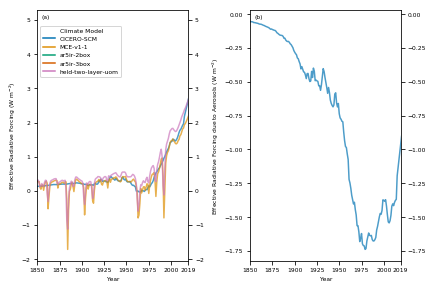

<IPython.core.display.Javascript object>

In [41]:
variable_to_plot_filters = [
    ["Effective Radiative Forcing", "Effective Radiative Forcing|50th quantile"],
    [
        "Effective Radiative Forcing|Anthropogenic|Aerosols",
        "Effective Radiative Forcing|Anthropogenic|Aerosols|50th quantile",
    ],
]
fig, axes_raw = plt.subplots(nrows=1, ncols=2)
axes = [axes_raw[0], axes_raw[1]]
ylabels = [
    "Effective Radiative Forcing (W m$^{-2}$)",
    "Effective Radiative Forcing due to Aerosols (W m$^{-2}$)",
]
annotations = ["(a)", "(b)"]
region_to_plot = "World"
scenario_models = "ssp585"
rcmip_climatemodel_calib_filter = ["*CALIB*", "MAGICC*_*", "*CMIP5-mean"]
broken_rcmip_results = ["*ESCIMO*"]  # up around 200...

years_to_plot = range(1850, 2050)


def prep_for_plot(idf):
    if isinstance(idf, pyam.IamDataFrame):
        udf = ScmDataFrame(idf)
    else:
        udf = idf.copy()

    return convert_scmdf_to_pyamdf_year_only(udf)


pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(
    EFFRF_PANEL_COMPARISON_FIGURE_PDF
)

db_plus_agg_cms = db_plus_agg.filter(variable=flatten(variable_to_plot_filters)).filter(
    climatemodel=rcmip_climatemodel_ignore_filter + broken_rcmip_results, keep=False
)
climatemodels = sorted(db_plus_agg_cms["climatemodel"].unique())
hue_order = sorted(climatemodels)
sns_colours = sns.color_palette("colorblind", len(climatemodels))

palette = {cm: sns_colours[i] for i, cm in enumerate(climatemodels)}

dashes_set = ("", (3, 3), (1, 1))
dashes = {
    cm: dashes_set[i // len(set(sns_colours))] for i, cm in enumerate(climatemodels)
}

for i, (var_filter, ax, ylabel, annotation) in enumerate(
    zip(variable_to_plot_filters, axes, ylabels, annotations)
):
    pdf_rcmip = prep_for_plot(
        db_plus_agg_cms.filter(
            variable=var_filter,
            region=region_to_plot,
            scenario=scenario_models,
            year=years_to_plot,
        )
    ).data

    pdf_sns = pd.concat([pdf_rcmip], sort=True)

    pdf_sns["Climate Model"] = pdf_sns["climatemodel"]

    sns.lineplot(
        data=pdf_sns,
        x="year",
        y="value",
        units="climatemodel",
        hue="Climate Model",
        hue_order=hue_order,
        style="Climate Model",
        dashes=dashes,
        palette=palette,
        ax=ax,
        estimator=None,
        alpha=0.7,
    )

    if i == 0:
        clean_labels(ax, ignore=["Category", "Climate Model"])
        ax.legend(loc="upper left", ncol=1, bbox_to_anchor=(0, 0.5, 0.5, 0.45))
    else:
        ax.get_legend().remove()

    ax.annotate(annotation, xy=(0.03, 0.965), xycoords="axes fraction")
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Year")
    ax.set_xlim([1850, 2019])
    ax.tick_params(labelright=True, right=True)
    ax.set_xticks(list(range(1850, 2011, 25)) + [2019])

plt.tight_layout()
pdf_to_save.savefig(fig)
#     break

pdf_to_save.close()